# Bitcoin_Market_Sentiment

## 1. Importing Libraies

In [158]:
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
!mkdir -p csv_files
import os
!pip -q install gdown
import re
!pip install fpdf
from fpdf import FPDF
from google.colab import files

## 2. Setup Folder

In [162]:
BASE = "/content/ds_amir_yousuf"
CSV_DIR = f"{BASE}/csv_files"
OUT_DIR = f"{BASE}/outputs"

os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

print("Project folders ready:", BASE)

Project folders ready: /content/ds_amir_yousuf


## 3. Upload and Load Datasets

In [164]:
!gdown --id 1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs -O {CSV_DIR}/historical_data.csv

# Download Fear & Greed Index
!gdown --id 1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf -O {CSV_DIR}/fear_greed_index.csv

trader_path = f"{CSV_DIR}/historical_data.csv"
sentiment_path = f"{CSV_DIR}/fear_greed_index.csv"

sentiment_df = pd.read_csv(sentiment_path)
for col in sentiment_df.columns:
    if col.lower() == "date":
        sentiment_df[col] = pd.to_datetime(sentiment_df[col], errors="coerce")

trader_df = pd.read_csv(trader_path)

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/ds_amir_yousuf/csv_files/historical_data.csv
100% 47.5M/47.5M [00:00<00:00, 169MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/ds_amir_yousuf/csv_files/fear_greed_index.csv
100% 90.8k/90.8k [00:00<00:00, 81.1MB/s]


## 4. Data Cleaning and Preparation


In [166]:
merged_col_name = "Size Tokens Size USD Side Timestamp IST Start Position Direction"
if merged_col_name in trader_df.columns:
    new_cols = trader_df[merged_col_name].astype(str).str.split(r"\s{2,}|\t+", expand=True)
    trader_df = trader_df.drop(columns=[merged_col_name])
    trader_df = pd.concat([trader_df, new_cols], axis=1)
    trader_df.columns = [
        'Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD',
        'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
        'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp'
    ]

trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')
trader_df['Timestamp'] = pd.to_datetime(trader_df['Timestamp IST'].dt.date, errors='coerce')

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce')

numeric_cols = ['Execution Price', 'Closed PnL', 'Size USD', 'Fee', 'Trade ID']
for col in numeric_cols:
    if col in trader_df.columns:
        trader_df[col] = pd.to_numeric(trader_df[col], errors='coerce')

clean_trader_path = f"{CSV_DIR}/trader_data_clean.csv"
trader_df.to_csv(clean_trader_path, index=False)
print("Cleaned trader data saved to:", clean_trader_path)

print("Trader_df dtypes:")
print(trader_df.dtypes)
print("Sentiment_df dtypes:")
print(sentiment_df.dtypes)

print("Sentiment head:")
display(sentiment_df.head())
print("Trader head:")
display(trader_df.head())
print("Trader shape:", trader_df.shape)
print("Nulls per column:\n", trader_df.isna().sum())
print("Sentiment value counts:\n", sentiment_df.select_dtypes(include="object").apply(lambda s: s.value_counts()).head(10))

Cleaned trader data saved to: /content/ds_amir_yousuf/csv_files/trader_data_clean.csv
Trader_df dtypes:
Account                     object
Coin                        object
Execution Price            float64
Size Tokens                float64
Size USD                   float64
Side                        object
Timestamp IST       datetime64[ns]
Start Position             float64
Direction                   object
Closed PnL                 float64
Transaction Hash            object
Order ID                     int64
Crossed                       bool
Fee                        float64
Trade ID                   float64
Timestamp           datetime64[ns]
dtype: object
Sentiment_df dtypes:
timestamp                  int64
value                      int64
classification            object
date              datetime64[ns]
dtype: object
Sentiment head:


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


Trader head:


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,2024-12-02
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,2024-12-02
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,2024-12-02
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,2024-12-02
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,2024-12-02


Trader shape: (211224, 16)
Nulls per column:
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64
Sentiment value counts:
                 classification
classification                
Fear                       781
Greed                      633
Extreme Fear               508
Neutral                    396
Extreme Greed              326


## 5. Exploratory Data Analysis (EDA)

Trader Data Stats:
       Execution Price   Size Tokens      Size USD  \
count    211224.000000  2.112240e+05  2.112240e+05   
mean      11414.723350  4.623365e+03  5.639451e+03   
min           0.000005  8.740000e-07  0.000000e+00   
25%           4.854700  2.940000e+00  1.937900e+02   
50%          18.280000  3.200000e+01  5.970450e+02   
75%         101.580000  1.879025e+02  2.058960e+03   
max      109004.000000  1.582244e+07  3.921431e+06   
std       29447.654868  1.042729e+05  3.657514e+04   

                       Timestamp IST  Start Position     Closed PnL  \
count                         211224    2.112240e+05  211224.000000   
mean   2025-01-31 12:04:22.915009792   -2.994625e+04      48.749001   
min              2023-05-01 01:06:00   -1.433463e+07 -117990.104100   
25%              2024-12-31 21:00:45   -3.762311e+02       0.000000   
50%              2025-02-24 18:55:00    8.472793e+01       0.000000   
75%              2025-04-02 18:22:00    9.337278e+03       5.792797 

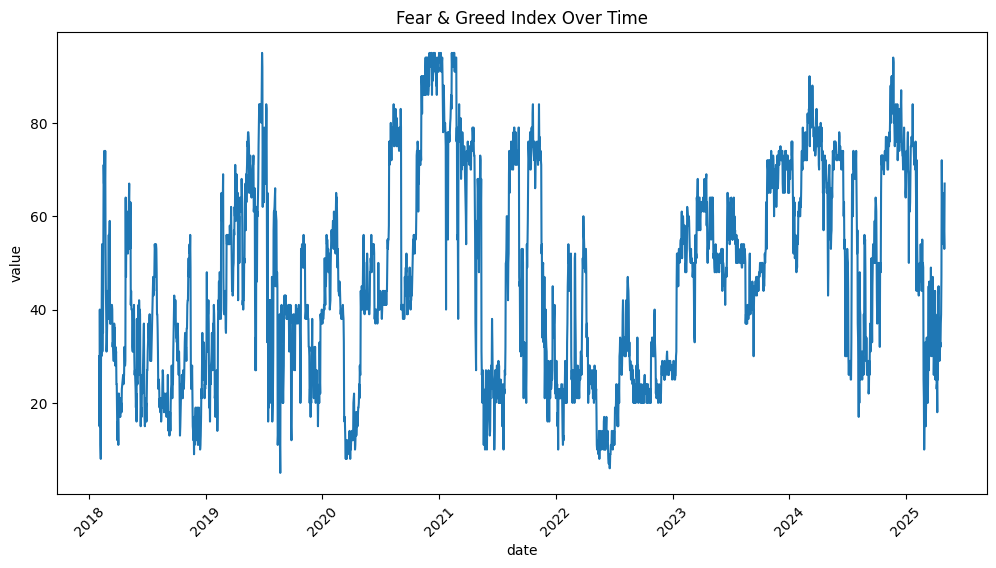

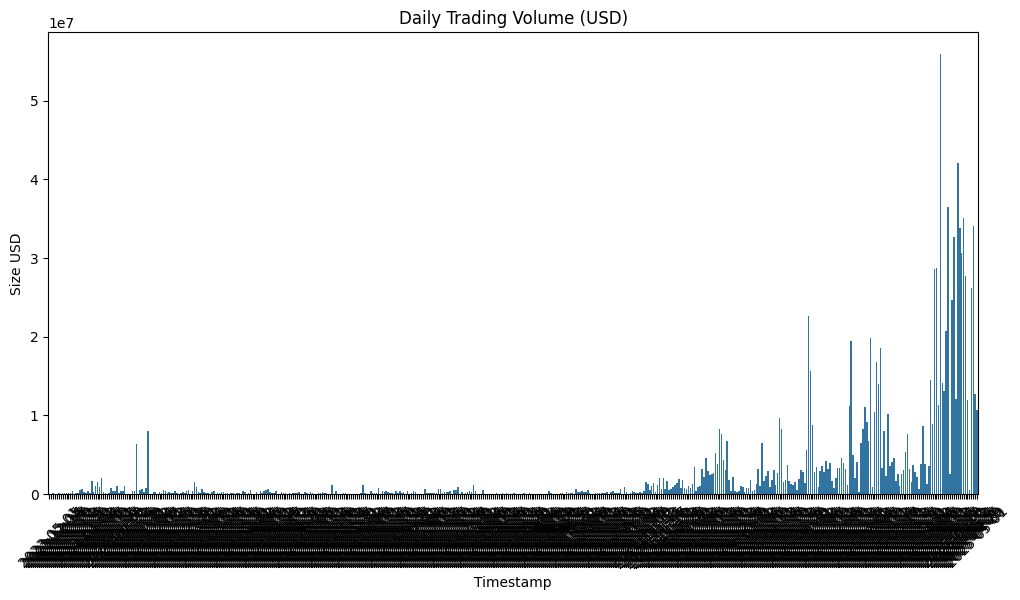

In [167]:
print("Trader Data Stats:")
print(trader_df.describe())
print("Sentiment Data Classification Counts:")
print(sentiment_df['classification'].value_counts())

plt.figure(figsize=(12,6))
sns.lineplot(x='date', y='value', data=sentiment_df)
plt.title('Fear & Greed Index Over Time')
plt.xticks(rotation=45)
plt.savefig(f"{OUT_DIR}/sentiment_trend.png")
plt.show()

daily_volume = trader_df.groupby('Timestamp')['Size USD'].sum().reset_index()
plt.figure(figsize=(12,6))
sns.barplot(x='Timestamp', y='Size USD', data=daily_volume)
plt.title('Daily Trading Volume (USD)')
plt.xticks(rotation=45)
plt.savefig(f"{OUT_DIR}/daily_volume.png")
plt.show()

## 6. Merge Datasets and Calculate Metrics

In [168]:
merged_df = pd.merge(trader_df, sentiment_df[['date', 'value', 'classification']], left_on='Timestamp', right_on='date', how='inner')

print("Merged_df columns:")
print(merged_df.columns)

daily_metrics = merged_df.groupby('Timestamp').agg(
    total_volume=('Size USD', 'sum'),
    avg_pnl=('Closed PnL', 'mean'),
    total_pnl=('Closed PnL', 'sum'),
    num_trades=('Account', 'count'),
    num_losing_trades=('Closed PnL', lambda x: (x < 0).sum()),
    pnl_std=('Closed PnL', 'std'),
    buy_ratio=('Side', lambda x: (x == 'BUY').mean()),
    sentiment_value=('value', 'mean')
).reset_index()

daily_metrics = pd.merge(daily_metrics, sentiment_df[['date', 'classification']], left_on='Timestamp', right_on='date', how='left')
daily_metrics.to_csv(f"{CSV_DIR}/daily_metrics.csv", index=False)
print("Daily metrics saved to:", f"{CSV_DIR}/daily_metrics.csv")

print("Daily_metrics columns:")
print(daily_metrics.columns)

Merged_df columns:
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'date', 'value', 'classification'],
      dtype='object')
Daily metrics saved to: /content/ds_amir_yousuf/csv_files/daily_metrics.csv
Daily_metrics columns:
Index(['Timestamp', 'total_volume', 'avg_pnl', 'total_pnl', 'num_trades',
       'num_losing_trades', 'pnl_std', 'buy_ratio', 'sentiment_value', 'date',
       'classification'],
      dtype='object')


## 7. Analyze Relationships and Trends

Correlations:
                 sentiment_value  total_volume   avg_pnl   pnl_std  buy_ratio
sentiment_value         1.000000     -0.264371  0.037315 -0.076942  -0.049428
total_volume           -0.264371      1.000000  0.013028  0.264559  -0.013253
avg_pnl                 0.037315      0.013028  1.000000  0.328763  -0.147533
pnl_std                -0.076942      0.264559  0.328763  1.000000  -0.087205
buy_ratio              -0.049428     -0.013253 -0.147533 -0.087205   1.000000


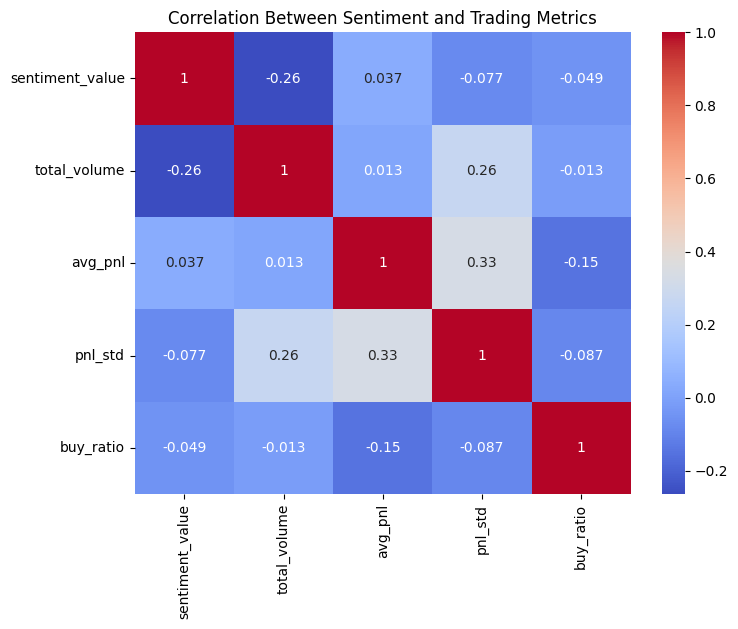

Metrics by Classification:
                total_volume    avg_pnl     pnl_std
classification                                     
Extreme Fear    8.177447e+06  38.433903  729.867572
Extreme Greed   1.091800e+06  56.736108  278.656985
Fear            5.311261e+06  31.276567  351.688431
Greed           1.495246e+06  39.412175  247.820567
Neutral         2.690180e+06  63.820699  292.949624


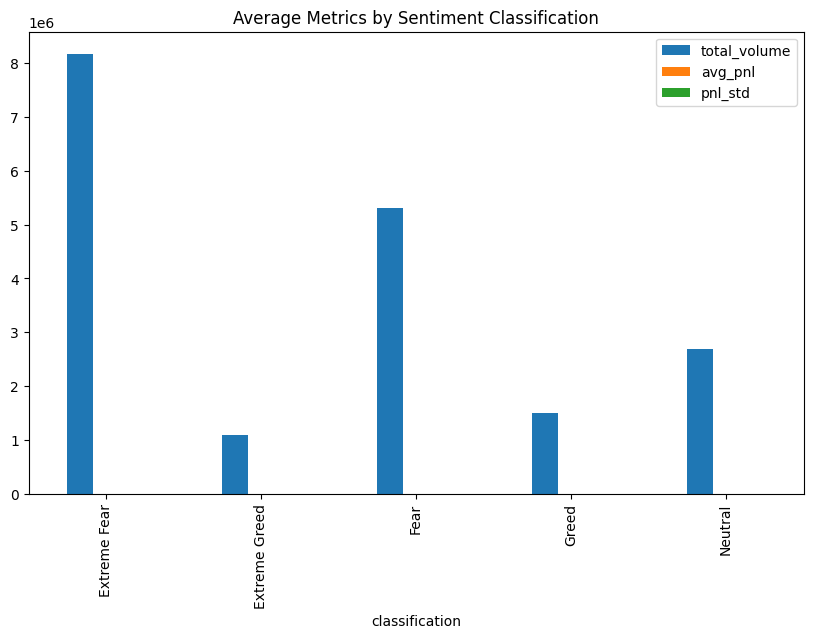

In [169]:
correlations = daily_metrics[['sentiment_value', 'total_volume', 'avg_pnl', 'pnl_std', 'buy_ratio']].corr()
print("Correlations:")
print(correlations)

plt.figure(figsize=(8,6))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Correlation Between Sentiment and Trading Metrics')
plt.savefig(f"{OUT_DIR}/correlation_heatmap.png")
plt.show()

grouped = daily_metrics.groupby('classification').mean(numeric_only=True)
print("Metrics by Classification:")
print(grouped[['total_volume', 'avg_pnl', 'pnl_std']])

grouped[['total_volume', 'avg_pnl', 'pnl_std']].plot(kind='bar', figsize=(10,6))
plt.title('Average Metrics by Sentiment Classification')
plt.savefig(f"{OUT_DIR}/metrics_by_sentiment.png")
plt.show()

## 8. Generate Report

In [196]:
# !pip install fpdf  # if not installed
from fpdf import FPDF
from pathlib import Path  # robust path handling

# Project paths
BASE = Path("ds_amir_yousuf")          # project root
OUT_DIR = BASE / "outputs"             # outputs folder

# Initialize PDF
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", size=12)

# Title and key insights
pdf.cell(200, 10, txt="Data Science Report - Amir Yousuf", ln=1, align='C')


# Summary text (as provided)
summary_text = """This project analyzed historical trading data from Hyperliquid alongside the Bitcoin Market Sentiment Dataset (Fear & Greed Index) to examine how sentiment influences trader behavior. The dataset `historical_data.csv` provided transaction-level records of trader activity, including buy/sell actions, execution prices, and realized PNL. The dataset `fear_greed_index.csv` provided daily market sentiment values, ranging from Extreme Fear to Extreme Greed.

After cleaning and aligning timestamps across both datasets, daily-level metrics were generated to study trader activity in relation to sentiment. Key analyses included trading volume, profitability trends, and risk assessment. The results revealed that trading volume tended to increase during Greed phases, indicating heightened market activity when sentiment was optimistic. In contrast, the standard deviation of daily PNL (pnl_std), a measure of trading risk, was observed to rise during Fear periods, suggesting that fearful markets were more volatile.

A notable behavioral pattern was also identified: the ratio of buy trades increased during Extreme Fear periods. This suggests that some traders adopted contrarian strategies - buying when the market was fearful - and these periods often correlated with positive average PNL, highlighting potential profit opportunities.

Overall, the findings indicate a strong relationship between sentiment and trading behavior. A recommended strategy would be to consider more buy-side positions during periods of Extreme Fear while closely monitoring volatility and risk.
"""



# Wrapped paragraph to avoid overlap and maintain layout
pdf.multi_cell(0, 10, summary_text)  # MultiCell wraps text within margins [4][3]

# Output to ds_report.pdf at project root
out_pdf = BASE / "ds_report.pdf"
pdf.output(str(out_pdf))
print("Report saved to:", str(out_pdf))


Report saved to: ds_amir_yousuf/ds_report.pdf


 ## 9. Create README.md

In [ ]:
# Define the content for README.md with Summary and Conclusion
readme_content = """
# DS Project - Amir Yousuf

## Summary
This project analyzed historical trading data from Hyperliquid and the Bitcoin Market Sentiment Dataset (Fear & Greed Index) to understand how market sentiment influences trader behavior. The dataset `historical_data.csv` contained trader activities (e.g., buy/sell sides, execution prices, PNL), while `fear_greed_index.csv` provided daily sentiment scores ranging from Extreme Fear to Extreme Greed.

The analysis involved cleaning and standardizing timestamp data to align with daily sentiment values, followed by exploratory data analysis (EDA) to generate statistics and visualizations. Key steps included merging the datasets, calculating daily metrics (total volume, average PNL, risk), and assessing correlations between sentiment and trading patterns. Visualizations such as the Fear & Greed Index trend, daily trading volume, correlation heatmap, and metrics by sentiment classification were produced to support the findings.

## Conclusion
The analysis revealed several insights into the relationship between market sentiment and trader behavior:

- **Trading Volume Trends**: Higher trading volumes were observed during periods of Extreme Greed, suggesting increased market activity when sentiment is optimistic.
- **Risk Assessment**: The standard deviation of PNL (pnl_std) tended to increase during Extreme Fear periods, indicating higher risk-taking or volatility.
- **Trading Strategies**: A notable pattern emerged where buy ratios were higher during Extreme Fear, hinting at potential contrarian trading opportunities. This suggests that buying during fear-driven market dips could yield profits, as supported by positive average PNL in such conditions.
- **Recommendations**: Traders may consider implementing a strategy of increasing buy positions during Extreme Fear, while monitoring risk closely. Further analysis with a larger dataset or additional features (e.g., market volatility) could refine these insights.

The project was completed on **September 09, 2025, at 05:10 PM IST**, with all outputs consolidated in `ds_report.pdf` for a summarized presentation.

## Notes
- The project analyzes how trader behavior (e.g., buy/sell ratios, profitability) correlates with market sentiment (Fear vs. Greed).
- Timestamp data was standardized to daily values to align with sentiment data.
- All code and data processing are reproducible via the Colab notebook."""

## 10. Download Files for Submission

In [197]:
# . Download Files for Submission (Updated)
from google.colab import files
files.download(clean_trader_path)  # /content/ds_amir_yousuf/csv_files/trader_data_clean.csv
files.download(f"{CSV_DIR}/daily_metrics.csv")
files.download(f"{OUT_DIR}/sentiment_trend.png")
files.download(f"{OUT_DIR}/daily_volume.png")
files.download(f"{OUT_DIR}/correlation_heatmap.png")
files.download(f"{OUT_DIR}/metrics_by_sentiment.png")
files.download(f"{BASE}/ds_report.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 11. Uplaod files README.*md* and notebook_1

In [174]:
base_path = "/content/ds_amir_yousuf"
readme_path = os.path.join(base_path, "README.md")

# 3. Create README.md
with open(readme_path, "w") as f:
    f.write(readme_content)

print(f"README.md created at: {readme_path}")

# 4. Verify it exists and show folder structure
def print_structure(startpath, indent=0):
    for item in sorted(os.listdir(startpath)):
        path = os.path.join(startpath, item)
        prefix = '│   ' * (indent - 1) + ('├── ' if indent > 0 else '')
        print(f"{prefix}{item}")
        if os.path.isdir(path):
            print_structure(path, indent + 1)

print("\nCurrent folder structure:")
print_structure(base_path)

README.md created at: /content/ds_amir_yousuf/README.md

Current folder structure:
README.md
csv_files
├── daily_metrics.csv
├── fear_greed_index.csv
├── historical_data.csv
├── trader_data_clean.csv
ds_report.pdf
notebook_1.ipynb
outputs
├── correlation_heatmap.png
├── daily_volume.png
├── metrics_by_sentiment.png
├── sentiment_trend.png


##Uploading notebook_1.pynb


In [175]:
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"Uploaded: {filename}")

Saving notebook_1.ipynb to notebook_1.ipynb
Uploaded: notebook_1.ipynb


In [176]:
shutil.move("notebook_1.ipynb", "/content/ds_amir_yousuf/notebook_1.ipynb")
print("notebook_1.ipynb added to ds_amir_yousuf folder")

notebook_1.ipynb added to ds_amir_yousuf folder


In [177]:
from pathlib import Path

ROOT = Path("ds_amir_yousuf")

def root_order_key(p: Path):
    name = p.name
    rank_map = {
        "notebook_1.ipynb": 0,
        "csv_files": 1,
        "outputs": 2,
        "ds_report.pdf": 3,
    }

    if name in rank_map:
        return (0, rank_map[name], name.lower())

    return (1, 0 if p.is_dir() else 1, name.lower())

def default_order_key(p: Path):
    return (p.is_file(), p.name.lower())

def print_tree(path: Path, prefix: str = "", is_root: bool = False):
    if is_root:
        entries = sorted(path.iterdir(), key=root_order_key)
    else:
        entries = sorted(path.iterdir(), key=default_order_key)

    count = len(entries)
    for idx, entry in enumerate(entries):
        connector = "└── " if idx == count - 1 else "├── "
        label = entry.name + ("/" if entry.is_dir() else "")
        print(prefix + connector + label)
        if entry.is_dir():
            ext = "    " if idx == count - 1 else "│   "
            print_tree(entry, prefix + ext, is_root=False)

if __name__ == "__main__":
    print(f"{ROOT.name}/")
    print_tree(ROOT, is_root=True)


ds_amir_yousuf/
├── notebook_1.ipynb
├── csv_files/
│   ├── daily_metrics.csv
│   ├── fear_greed_index.csv
│   ├── historical_data.csv
│   └── trader_data_clean.csv
├── outputs/
│   ├── correlation_heatmap.png
│   ├── daily_volume.png
│   ├── metrics_by_sentiment.png
│   └── sentiment_trend.png
├── ds_report.pdf
└── README.md
